# TensorFlow Regression Example

## Creating Data

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [39]:
# 1 Million Points
x_data = np.linspace(0.0,10.0,1000000)

In [40]:
noise = np.random.randn(len(x_data))

In [41]:
# y = mx + b + noise_levels
b = 5

y_true =  (0.5 * x_data ) + 5 + noise

In [42]:
my_data = pd.concat(
    [
        pd.DataFrame(data=x_data,columns=['X Data']), 
        pd.DataFrame(data=y_true,columns=['Y'])
    ],
    axis=1
)

In [43]:
my_data.head()

,X Data,Y
0,0.00000,3.795053
1,0.00001,3.818817
2,0.00002,4.210509
3,0.00003,4.482550
4,0.00004,6.309349


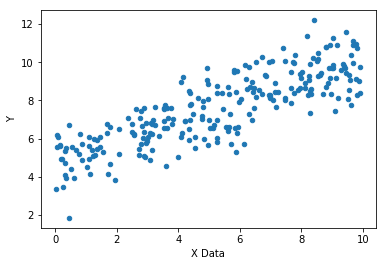

In [44]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')

# TensorFlow
## Batch Size

We will take the data in batches (1,000,000 points is a lot to pass in at once)

In [45]:
import tensorflow as tf

In [46]:
# Random 10 points to grab
batch_size = 8

** Variables **

In [47]:
m = tf.Variable(0.5)
b = tf.Variable(1.0)

** Placeholders **

In [48]:
xph = tf.placeholder(tf.float32,[batch_size])
yph = tf.placeholder(tf.float32,[batch_size])

** Graph **

In [49]:
y_model = m*xph + b

** Loss Function **

In [50]:
error = tf.reduce_sum(tf.square(yph-y_model))

** Optimizer **

In [51]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.001)
train = optimizer.minimize(error)

** Initialize Variables **

In [52]:
init = tf.global_variables_initializer()

### Session

In [53]:
with tf.Session() as sess:
    
    sess.run(init)
    
    batches = 1000
    
    for i in range(batches):
        
        rand_ind = np.random.randint(len(x_data),size=batch_size)
        
        feed = {xph:x_data[rand_ind],yph:y_true[rand_ind]}
        
        sess.run(train,feed_dict=feed)
        
    model_m,model_b = sess.run([m,b])

In [54]:
model_m

0.50825226

In [55]:
model_b

4.8967834

### Results

In [56]:
y_hat = x_data * model_m + model_b

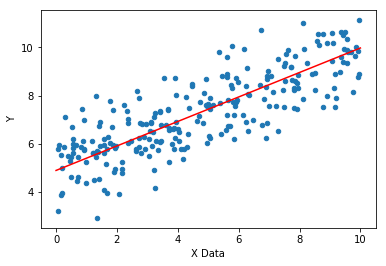

In [57]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(x_data,y_hat,'r')

## tf.estimator API

Much simpler API for basic tasks like regression! We'll talk about more abstractions like TF-Slim later on.

In [58]:
feat_cols = [tf.feature_column.numeric_column('x',shape=[1])]

In [59]:
estimator = tf.estimator.LinearRegressor(feature_columns=feat_cols)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/bq/vdmp92y957ddk9_2z23j_gbm0000gp/T/tmpl3tu57es', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1a306ffe80>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


### Train Test Split

We haven't actually performed a train test split yet! So let's do that on our data now and perform a more realistic version of a Regression Task

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
x_train, x_eval, y_train, y_eval = train_test_split(x_data,y_true,test_size=0.3, random_state = 101)

In [62]:
print(x_train.shape)
print(y_train.shape)

print(x_eval.shape)
print(y_eval.shape)

(700000,)
(700000,)
(300000,)
(300000,)


### Set up Estimator Inputs

In [63]:
# Can also do .pandas_input_fn
input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=None,shuffle=True)

In [64]:
train_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_train},y_train,batch_size=4,num_epochs=1000,shuffle=False)

In [65]:
eval_input_func = tf.estimator.inputs.numpy_input_fn({'x':x_eval},y_eval,batch_size=4,num_epochs=1000,shuffle=False)

### Train the Estimator

In [66]:
estimator.train(input_fn=input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /var/folders/bq/vdmp92y957ddk9_2z23j_gbm0000gp/T/tmpl3tu57es/model.ckpt.
INFO:tensorflow:loss = 214.22668, step = 1
INFO:tensorflow:global_step/sec: 482.497
INFO:tensorflow:loss = 7.5316043, step = 101 (0.208 sec)
INFO:tensorflow:global_step/sec: 920.827
INFO:tensorflow:loss = 19.295002, step = 201 (0.108 sec)
INFO:tensorflow:global_step/sec: 961.864
INFO:tensorflow:loss = 6.667385, step = 301 (0.104 sec)
INFO:tensorflow:global_step/sec: 896.008
INFO:tensorflow:loss = 16.498545, step = 401 (0.111 sec)
INFO:tensorflow:global_step/sec: 918.03
INFO:tensorflow:loss = 1.7064514, step = 501 (0.109 sec)
INFO:tensorflow:global_step/sec: 926.551
INFO:tensorflow:loss = 2.6224031, step = 601 (0.108 sec)
INFO:tensorflow

### Evaluation

In [67]:
train_metrics = estimator.evaluate(input_fn=train_input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-18-23:49:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/bq/vdmp92y957ddk9_2z23j_gbm0000gp/T/tmpl3tu57es/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-06-18-23:49:12
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.1513346, global_step = 1000, loss = 4.6053386


In [68]:
eval_metrics = estimator.evaluate(input_fn=eval_input_func,steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-06-18-23:49:12
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/bq/vdmp92y957ddk9_2z23j_gbm0000gp/T/tmpl3tu57es/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [100/1000]
INFO:tensorflow:Evaluation [200/1000]
INFO:tensorflow:Evaluation [300/1000]
INFO:tensorflow:Evaluation [400/1000]
INFO:tensorflow:Evaluation [500/1000]
INFO:tensorflow:Evaluation [600/1000]
INFO:tensorflow:Evaluation [700/1000]
INFO:tensorflow:Evaluation [800/1000]
INFO:tensorflow:Evaluation [900/1000]
INFO:tensorflow:Evaluation [1000/1000]
INFO:tensorflow:Finished evaluation at 2018-06-18-23:49:14
INFO:tensorflow:Saving dict for global step 1000: average_loss = 1.1559324, global_step = 1000, loss = 4.6237297


In [69]:
print("train metrics: {}".format(train_metrics))
print("eval metrics: {}".format(eval_metrics))

train metrics: {'average_loss': 1.1513346, 'loss': 4.6053386, 'global_step': 1000}
eval metrics: {'average_loss': 1.1559324, 'loss': 4.6237297, 'global_step': 1000}


### Predictions

In [70]:
input_fn_predict = tf.estimator.inputs.numpy_input_fn({'x':np.linspace(0,10,10)},shuffle=False)

In [71]:
list(estimator.predict(input_fn=input_fn_predict))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/bq/vdmp92y957ddk9_2z23j_gbm0000gp/T/tmpl3tu57es/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'predictions': array([4.261953], dtype=float32)},
 {'predictions': array([4.955213], dtype=float32)},
 {'predictions': array([5.6484737], dtype=float32)},
 {'predictions': array([6.341734], dtype=float32)},
 {'predictions': array([7.034994], dtype=float32)},
 {'predictions': array([7.7282543], dtype=float32)},
 {'predictions': array([8.4215145], dtype=float32)},
 {'predictions': array([9.114775], dtype=float32)},
 {'predictions': array([9.808035], dtype=float32)},
 {'predictions': array([10.501295], dtype=float32)}]

In [72]:
predictions = []# np.array([])
for x in estimator.predict(input_fn=input_fn_predict):
    predictions.append(x['predictions'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/bq/vdmp92y957ddk9_2z23j_gbm0000gp/T/tmpl3tu57es/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [73]:
predictions

[array([4.261953], dtype=float32),
 array([4.955213], dtype=float32),
 array([5.6484737], dtype=float32),
 array([6.341734], dtype=float32),
 array([7.034994], dtype=float32),
 array([7.7282543], dtype=float32),
 array([8.4215145], dtype=float32),
 array([9.114775], dtype=float32),
 array([9.808035], dtype=float32),
 array([10.501295], dtype=float32)]

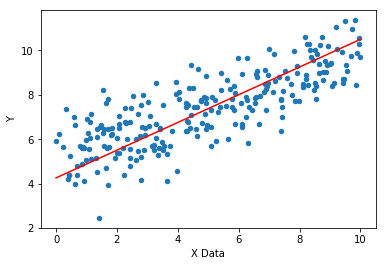

In [74]:
my_data.sample(n=250).plot(kind='scatter',x='X Data',y='Y')
plt.plot(np.linspace(0,10,10),predictions,'r')

# Great Job!